In [31]:
# -*- coding:utf-8 -*-
import os
import numpy as np
from numpy.linalg import eig
from skimage.color import rgb2ycbcr
from skimage.color import ycbcr2rgb
from skimage.measure import compare_psnr
from skimage.measure import compare_ssim
from scipy.misc import imresize
from scipy.signal import convolve
from skimage.util import view_as_windows
import  skimage.io as io
from skimage import data_dir
from sklearn.decomposition import dict_learning_online
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import sparse_encode
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import spams

In [2]:
str = '/Users/shanlinsun/Documents/GitHub/Single_Image_SR/CVPR08-SR/Data/Training/*.bmp'
coll = io.ImageCollection(str)

In [3]:
dic_size = 1000
upscale = 3
patch_size = 3
overlap = 1
filters = [[[1,0,0,-1]],[[1],[0],[0],[-1]],[[0.5,0,0,-1,0,0,0.5]],[[0.5],[0],[0],[-1],[0],[0],[0.5]]]

In [4]:
def modcrop(Input_Img, upscale):
    mod = np.remainder(Input_Img.shape, upscale)
    new_shape = Input_Img.shape - mod
    Output_Img = Input_Img[0:new_shape[0], 0:new_shape[1]]
    
    return Output_Img

In [5]:
window_size = patch_size * upscale
step = (patch_size - overlap) * upscale
for i in range(len(coll)):
    
    # convert rgb image to YCcCr color space
    if coll[i].shape[2] == 3:
        H_Img = rgb2ycbcr(coll[i])
        # only keep y-channle for 'texture'
        H_Img = H_Img[:,:,0]
    else:
        H_Img = coll[i]
        
    # Load training high-res. image set and resample it
    H_Img = modcrop(H_Img, upscale) # crop a bit (to simplify scaling issues)
    # Scale down images
    L_Img = imresize(H_Img, 1/upscale, interp='bicubic', mode = 'F')
    
    M_Img = imresize(L_Img, H_Img.shape, interp='bicubic', mode = 'F')
    
    # remove the low frequency content of an image
    RI_Img = H_Img - M_Img 

    # compute first order and second order gradient, 
    # generating four feature maps per low-resolution image
    M_Img_1 = convolve(M_Img, filters[0], 'same')
    M_Img_2 = convolve(M_Img, filters[1], 'same')
    M_Img_3 = convolve(M_Img, filters[2], 'same')
    M_Img_4 = convolve(M_Img, filters[3], 'same')
    
    # generating four feature maps per high-resolution image
    H_Img_1 = convolve(H_Img, filters[0], 'same')
    H_Img_2 = convolve(H_Img, filters[1], 'same')
    H_Img_3 = convolve(H_Img, filters[2], 'same')
    H_Img_4 = convolve(H_Img, filters[3], 'same')

    # slice out low-res patches
    window_size = patch_size * upscale
    step = (patch_size - overlap) * upscale
    patch_array_1 = view_as_windows(M_Img_1, window_size, step)
    patch_array_1 = patch_array_1.reshape(-1, patch_array_1.shape[-2]*patch_array_1.shape[-1])
    patch_array_2 = view_as_windows(M_Img_2, window_size, step)
    patch_array_2 = patch_array_2.reshape(-1, patch_array_2.shape[-2]*patch_array_2.shape[-1])
    patch_array_3 = view_as_windows(M_Img_3, window_size, step)
    patch_array_3 = patch_array_3.reshape(-1, patch_array_3.shape[-2]*patch_array_3.shape[-1])
    patch_array_4 = view_as_windows(M_Img_4, window_size, step)
    patch_array_4 = patch_array_4.reshape(-1, patch_array_4.shape[-2]*patch_array_4.shape[-1])
    
    # slice out high-res patches
    patch_array_h1 = view_as_windows(H_Img_1, window_size, step)
    patch_array_h1 = patch_array_h1.reshape(-1, patch_array_h1.shape[-2]*patch_array_h1.shape[-1])
    patch_array_h2 = view_as_windows(H_Img_2, window_size, step)
    patch_array_h2 = patch_array_h2.reshape(-1, patch_array_h2.shape[-2]*patch_array_h2.shape[-1])
    patch_array_h3 = view_as_windows(H_Img_3, window_size, step)
    patch_array_h3 = patch_array_h3.reshape(-1, patch_array_h3.shape[-2]*patch_array_h3.shape[-1])
    patch_array_h4 = view_as_windows(H_Img_4, window_size, step)
    patch_array_h4 = patch_array_h4.reshape(-1, patch_array_h4.shape[-2]*patch_array_h4.shape[-1])

    # slice out residual patches
    patch_array_ri = view_as_windows(RI_Img, window_size, step)
    patch_array_ri = patch_array_ri.reshape(-1, patch_array_ri.shape[-2]*patch_array_ri.shape[-1])

    
    # stack four feature maps of low-res image together
    patch_array_l = np.concatenate((patch_array_1,patch_array_2,patch_array_3,patch_array_4),axis = 1)
    patch_array_h = np.concatenate((patch_array_h1,patch_array_h2,patch_array_h3,patch_array_h4),axis = 1)
    
    if i == 0:
        feature_l = patch_array_l
        feature_h = patch_array_h
        feature_ri = patch_array_ri
    else:
        feature_l = np.concatenate((feature_l,patch_array_l),axis = 0)
        feature_h = np.concatenate((feature_h,patch_array_h),axis = 0)
        feature_ri = np.concatenate((feature_ri,patch_array_ri),axis = 0)

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()
/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [22]:
from sklearn.decomposition import PCA
clf = PCA(n_components=30)
feature_l_pca = clf.fit_transform(feature_l)
feature_h_pca = clf.transform(feature_h)

threshold = 5000
idx = np.var(feature_l_pca,1)>5000
feature_l_pca = feature_l_pca[idx,:]
feature_h_pca = feature_h_pca[idx,:]

feature_pca = np.concatenate((feature_l_pca, feature_h_pca), axis = 1)

In [42]:
feature_ri = feature_ri[idx, :]

In [40]:
code, Dic = dict_learning_online(feature_pca, n_components = dic_size, alpha = 0.1, n_iter = 50, batch_size = 500, verbose = 20)

Iteration   0 (elapsed time:   1s,  0.0mn)
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new ran

Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new random atom
Adding new 

Iteration   2 (elapsed time:  28s,  0.5mn)
Iteration   3 (elapsed time:  49s,  0.8mn)
Iteration   4 (elapsed time:  66s,  1.1mn)
Iteration   5 (elapsed time:  85s,  1.4mn)
Iteration   6 (elapsed time:  102s,  1.7mn)
Iteration   7 (elapsed time:  120s,  2.0mn)
Iteration   8 (elapsed time:  141s,  2.4mn)
Iteration   9 (elapsed time:  160s,  2.7mn)
Iteration  10 (elapsed time:  180s,  3.0mn)
Iteration  11 (elapsed time:  201s,  3.4mn)
Iteration  12 (elapsed time:  238s,  4.0mn)
Iteration  13 (elapsed time:  291s,  4.9mn)
Iteration  14 (elapsed time:  325s,  5.4mn)
Iteration  15 (elapsed time:  352s,  5.9mn)
Iteration  16 (elapsed time:  377s,  6.3mn)
Iteration  17 (elapsed time:  403s,  6.7mn)
Iteration  18 (elapsed time:  430s,  7.2mn)
Iteration  19 (elapsed time:  457s,  7.6mn)
Iteration  20 (elapsed time:  485s,  8.1mn)
Iteration  21 (elapsed time:  515s,  8.6mn)
Iteration  22 (elapsed time:  545s,  9.1mn)
Iteration  23 (elapsed time:  575s,  9.6mn)
Iteration  24 (elapsed time:  605s, 

AttributeError: 'numpy.ndarray' object has no attribute 'fit'

In [43]:
from numpy.linalg import inv
Dh = np.dot(inv(np.dot(code.T, code)), np.dot(code.T, feature_ri))

In [72]:
Test_Img = io.imread('/Users/shanlinsun/Desktop/USC/2018_Summer/ScSR/Data/Testing/gnd.bmp')
Test_Img = rgb2ycbcr(Test_Img)
Test_Img_y = Test_Img[:,:,0]
Test_Img_cb = Test_Img[:,:,1]
Test_Img_cr = Test_Img[:,:,2]

In [73]:
step = 1
# Load training high-res. image set and resample it
Test_Img_y = modcrop(Test_Img_y, upscale) # crop a bit (to simplify scaling issues)
M_Img = imresize(Test_Img_y, 1/upscale, interp='bicubic', mode = 'F')
M_Img = imresize(M_Img, Test_Img_y.shape, interp='bicubic', mode = 'F')

/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.
/Applications/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [74]:
M_Img = np.pad(M_Img, patch_size*upscale-step, mode='symmetric')
H_Img = np.pad(Test_Img_y, patch_size*upscale-step, mode='symmetric')
RI_Img = np.zeros(M_Img.shape)

In [75]:
# compute first order and second order gradient, 
# generating four feature maps per low-resolution image
M_Img_1 = convolve(M_Img, filters[0], 'same')
M_Img_2 = convolve(M_Img, filters[1], 'same')
M_Img_3 = convolve(M_Img, filters[2], 'same')
M_Img_4 = convolve(M_Img, filters[3], 'same')

# generating four feature maps per high-resolution image
H_Img_1 = convolve(H_Img, filters[0], 'same')
H_Img_2 = convolve(H_Img, filters[1], 'same')
H_Img_3 = convolve(H_Img, filters[2], 'same')
H_Img_4 = convolve(H_Img, filters[3], 'same')

In [76]:
gridx = np.arange(0, M_Img_1.shape[0]-patch_size*upscale+1,step, dtype=int)
gridy = np.arange(0, M_Img_1.shape[1]-patch_size*upscale+1,step, dtype=int)

In [61]:
window_size = patch_size*upscale
for xx in gridx:
    for yy in gridy:
        # preprocessing gradient map
        mPatchFea_1 = M_Img_1[xx:xx+window_size,yy:yy+window_size]
        mPatchFea_1 = mPatchFea_1.flatten()
        mPatchFea_2 = M_Img_2[xx:xx+window_size,yy:yy+window_size]
        mPatchFea_2 = mPatchFea_2.flatten()
        mPatchFea_3 = M_Img_3[xx:xx+window_size,yy:yy+window_size]
        mPatchFea_3 = mPatchFea_3.flatten()
        mPatchFea_4 = M_Img_4[xx:xx+window_size,yy:yy+window_size]
        mPatchFea_4 = mPatchFea_4.flatten()
        mPatchFea = np.concatenate((mPatchFea_1, mPatchFea_2, mPatchFea_3, mPatchFea_4))
        
        # preprocessing gradient map
        hPatchFea_1 = H_Img_1[xx:xx+window_size,yy:yy+window_size]
        hPatchFea_1 = hPatchFea_1.flatten()
        hPatchFea_2 = H_Img_2[xx:xx+window_size,yy:yy+window_size]
        hPatchFea_2 = hPatchFea_2.flatten()
        hPatchFea_3 = H_Img_3[xx:xx+window_size,yy:yy+window_size]
        hPatchFea_3 = hPatchFea_3.flatten()
        hPatchFea_4 = H_Img_4[xx:xx+window_size,yy:yy+window_size]
        hPatchFea_4 = hPatchFea_4.flatten()
        hPatchFea = np.concatenate((hPatchFea_1, hPatchFea_2, hPatchFea_3, hPatchFea_4))

        # reshape y for sparse coder requirement
        feature_l = mPatchFea.reshape(1,-1)
        feature_h = hPatchFea.reshape(1,-1)

        # pca 324->30
        feature_l_pca = clf.transform(feature_l)
        feature_h_pca = clf.transform(feature_h)
        
        feature_pca = np.concatenate((feature_l_pca, feature_h_pca), axis = 1)

        # sparse recovery
        w = sparse_encode(feature_pca, Dic, alpha=0.1, max_iter = 50)
        
        # compute the residual patch
        riPatch = np.dot(w,Dh)
        
        # reshape back to the (patch_size,patch_size) patch 
        riPatch = riPatch.reshape(window_size, window_size)
        
        # patch residual patch onto the image
        RI_Img[xx:xx+window_size,yy:yy+window_size] += riPatch

In [77]:
Test_Img_y.shape

(255, 255)

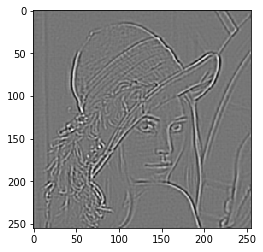

In [62]:
ri_Img = RI_Img[window_size-1:-window_size+1,window_size-1:-window_size+1]/81
plt.imshow(ri_Img, cmap='gray')

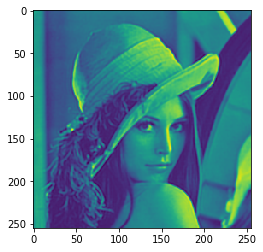

In [63]:
Bi_Img = M_Img[window_size-1:-window_size+1,window_size-1:-window_size+1]
h_Img = ri_Img + Bi_Img
plt.imshow(h_Img)

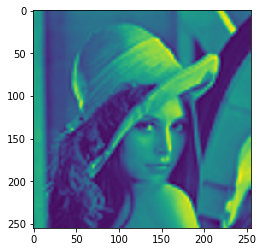

In [64]:
plt.imshow(Bi_Img)

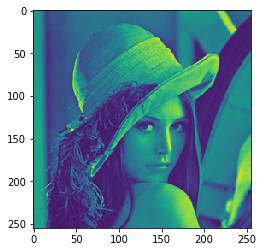

In [65]:
plt.imshow(Test_Img_y)

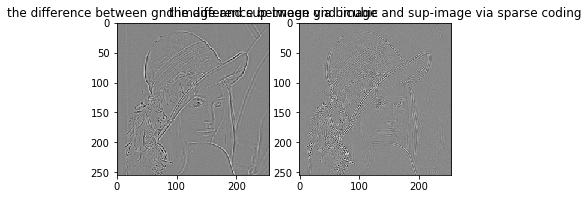

In [66]:
plt.subplot(1,2,1)
plt.title('the difference between gnd image and sup-image via bicubic')
plt.imshow(Bi_Img-Test_Img_y,cmap = 'gray')
plt.subplot(1,2,2)
plt.title('the difference between gnd image and sup-image via sparse coding')
plt.imshow(h_Img-Test_Img_y,cmap = 'gray')

In [67]:
psnr = compare_psnr(Test_Img_y.astype(float),h_Img.astype(float),data_range=h_Img.max() - h_Img.min())
ssim = compare_ssim(Test_Img_y.astype(float),h_Img.astype(float),data_range=h_Img.max() - h_Img.min())
print('srsc_v2_upscale_3, psnr:', psnr)
print('srsc_v2_upscale_3, ssim:', ssim)

srsc_v2_upscale_3, psnr: 32.373075880600894
srsc_v2_upscale_3, ssim: 0.939261521586465


In [68]:
psnr = compare_psnr(Test_Img_y.astype(float),Bi_Img.astype(float),data_range=Bi_Img.max() - Bi_Img.min())
ssim = compare_ssim(Test_Img_y.astype(float),Bi_Img.astype(float),data_range=Bi_Img.max() - Bi_Img.min())
print('bicubic_upscale_3, psnr:', psnr)
print('bicubic_upscale_3, ssim:', ssim)

bicubic_upscale_3, psnr: 26.100461070663815
bicubic_upscale_3, ssim: 0.8147941229354244
